<a href="https://colab.research.google.com/github/frankzamma/AntiPiracyPlatform/blob/main/Notebook/TestQLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training e Test con Q-Learning
In questo notebook è presente il training di Q*Bert sfruttando l'algoritmo Q-Learning


## Download Repository

Download della repository per utilizzare le classi create su Google Colab

In [1]:
from google.colab import userdata

In [2]:
! git clone https://{userdata.get('TokenGithub')}"@github.com/amigli/Q-Bert_RL.git"

Cloning into 'Q-Bert_RL'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 208 (delta 113), reused 124 (delta 53), pack-reused 0 (from 0)
Receiving objects: 100% (208/208), 1.34 MiB | 10.15 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [2]:
%cd Q-Bert_RL/

/content/Q-Bert_RL


## Configurazione salvataggio video

Configurazione di Google Drive per salvare i video dell'esecuzione dopo il training

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [14]:
directory_videos = '/content/Videos/'

## Installazione dei requirements

Vengono installati tutti i moduli necessari dal file requirements.txt

In [5]:
!pip install -r requirements.txt

## Training



In [9]:
from Algorithms.QBertAgent_QLearning import QBAgent
import gymnasium as gym
import ale_py
from tqdm.notebook import tqdm
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
from EnvironmentWrappers.QbertObservationWrapper import QbertObservationWrapperTuple
from EnvironmentWrappers.RewardFunction import RewardFunction
gym.register_envs(ale_py)

# hyperparameters
learning_rate = 0.01
n_episodes = 3000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

## TRAINING
env = gym.make("ALE/Qbert-ram-v5")
env =  QbertObservationWrapperTuple(env)
agent = QBAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

# history = []
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    rewardFunction = RewardFunction(obs[0])
    obs = obs[1]
    while not done:
        action = agent.get_action(obs, True)

        next_obs, reward, terminated, truncated, info = env.step(action)
        reward = rewardFunction.calculate_reward(next_obs, reward)
        next_obs = next_obs[1]

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

env.close()



  0%|          | 0/3000 [00:00<?, ?it/s]

AttributeError: 'QbertObservationWrapperTuple' object has no attribute 'return_queue'

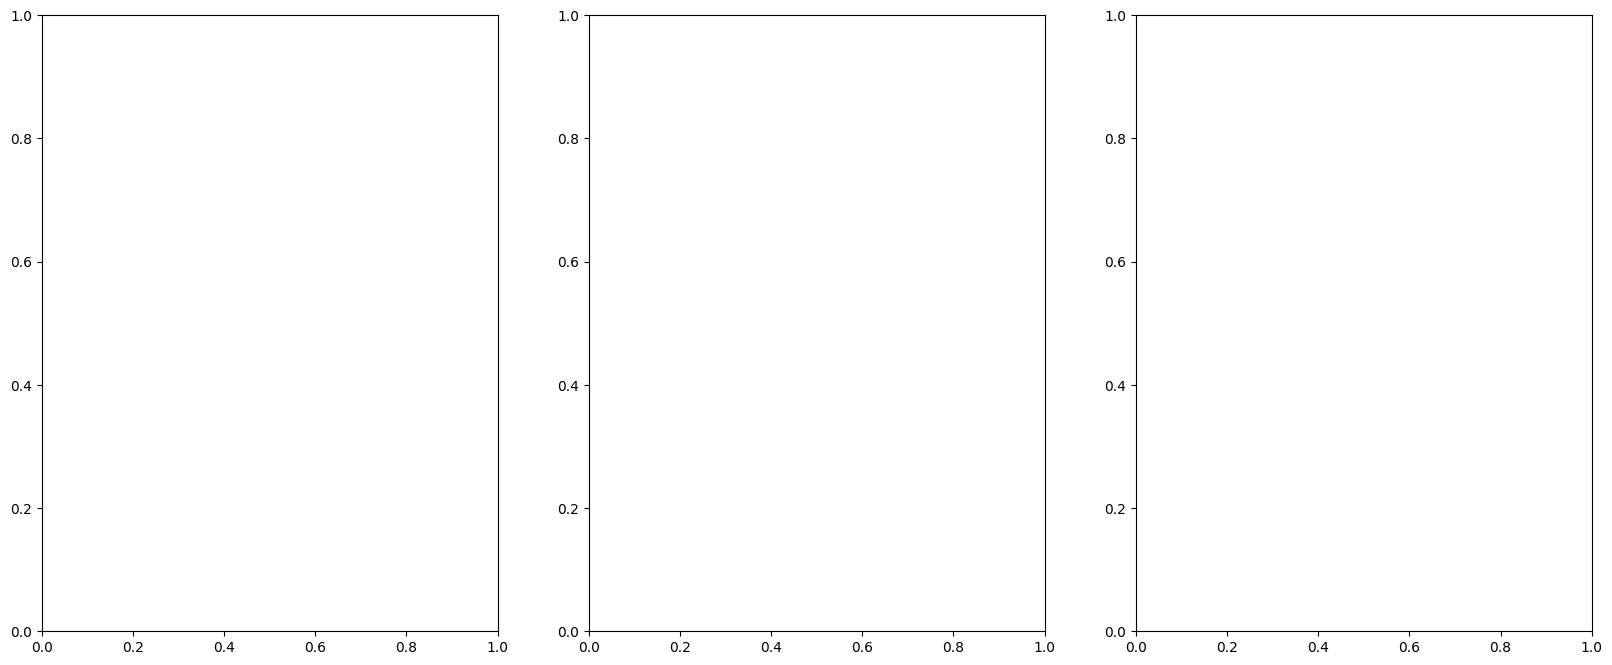

In [11]:
from matplotlib import pyplot as plt
import numpy as np

# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# np.convolve will compute the rolling mean for 100 episodes

axs[0].plot(np.convolve(env.return_queue, np.ones(100)))
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(np.convolve(env.length_queue, np.ones(100)))
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

axs[2].plot(np.convolve(agent.training_error, np.ones(100)))
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()

# Utilizzo Policy

Di seguito viente utilizzata la policy precedentemente calcolata per registrare degli episodi

In [15]:
num_eval_episodes = 10

env = gym.make("ALE/Qbert-ram-v5", render_mode="rgb_array")
env =  QbertObservationWrapperTuple(env)
env = RecordVideo(env, video_folder=directory_videos, name_prefix="eval",
                  episode_trigger=lambda x: True)
env = RecordEpisodeStatistics(env, buffer_length=num_eval_episodes)


for episode_num in range(num_eval_episodes):
    obs, info = env.reset()
    rewardFunction = RewardFunction(obs[0])
    obs = obs[1]
    done = False

    while not done:
        action = agent.get_action(obs, False)
        next_obs, reward, terminated, truncated, info = env.step(action)
        reward = rewardFunction.calculate_reward(next_obs, reward)
        obs =  next_obs[1]

        done = terminated or truncated
env.close()

print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')

print("Training terminato")


Exception ignored in: <function RecordVideo.__del__ at 0x7dcb6c39b920>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py", line 415, in __del__
    if len(self.recorded_frames) > 0:
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: 'RecordVideo' object has no attribute 'recorded_frames'


Episode time taken: deque([0.575788, 0.538835, 0.527885, 0.518968, 0.533042, 0.520494, 0.528948, 0.517288, 0.534733, 0.526119], maxlen=10)
Episode total rewards: deque([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], maxlen=10)
Episode lengths: deque([1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038], maxlen=10)
Training terminato
